# Задание 1

**Условия**: одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Входные данные:**

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

Для анализов результатов эксперимента, учитывая имеющиеся данные, были выбраны следующие метрики:

+ показатели дохода, такие как средний чек (в данном случае, средний чек = ARPPU), ARPU (конверсия * ARPPU), чтобы увидеть повлияло ли изменение на выручку
+ конверсия в покупку (CR), чтобы посмотреть повлияло ли изменение на частоту покупок

## Данные

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats import proportion as proportion, power as smp, gof as smg
from scipy.stats import norm, mannwhitneyu, shapiro
import matplotlib.pyplot as plt
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [2]:
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-prohorova-18/final_project1/Проект_2_checks.csv', sep=';')

In [3]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-prohorova-18/final_project1/Проект_2_groups.csv', sep=';')

In [4]:
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-prohorova-18/final_project1/Проект_2_active_studs.csv', sep=';')

In [5]:
group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-prohorova-18/final_project1/Проект_2_group_add.csv', sep=',')

In [24]:
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [25]:
checks.shape

(541, 2)

In [14]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [15]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [22]:
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [23]:
groups.shape

(74484, 2)

In [17]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [18]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [6]:
groups = groups.rename(columns={'id':'student_id'})

In [26]:
active_studs.head(2)

,student_id
0,581585
1,5723133


In [27]:
active_studs.shape

(8341, 1)

In [19]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [21]:
active_studs.nunique()

student_id    8341
dtype: int64

In [48]:
group_add

,student_id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [7]:
group_add = group_add.rename(columns={'id':'student_id'})

In [8]:
groups = pd.concat([groups, group_add], ignore_index=True)

In [9]:
groups

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Во всех датасетах нет дубликатов и пропущенных значений. Пользователей платформы - 74576 человек, были активны во время эксперимента 8341 пользователь, сделали покупку 541 пользователь.

Проверим, совпадают ли id пользователей в датасетах:

In [61]:
pd.merge(active_studs, groups, on='student_id').shape

(8341, 2)

In [62]:
pd.merge(checks, groups, on='student_id').shape

(541, 3)

In [63]:
pd.merge(active_studs, checks, on='student_id').shape

(392, 2)

После объединения датасетов можно заметить, что в датасете с покупками на 149 пользователей меньше (т.е. эти пользователи не заходили на платформу, но совершили оплату). Сохраним этих пользователей в отдельный датасет. 

In [10]:
df_no_active_studs = pd.merge(pd.merge(active_studs, checks, on='student_id'), checks, on='student_id', how='right')\
.fillna('no')\
.query('rev_x == "no"')\
.reset_index(drop=True)\
.drop(['rev_x'], axis=1)\
.rename(columns={'rev_y': 'rev'})

In [11]:
df_no_active_studs

,student_id,rev
0,3185,690.0
1,25973,690.0
2,26280,690.0
3,100645,630.0
4,102534,580.0
...,...,...
144,5291900,199.0
145,5331842,290.0
146,5486319,199.0
147,5562806,398.0


Объединим датафреймы для дальнейшей работы:

In [12]:
active_studs = pd.merge(active_studs, groups, on='student_id')

In [13]:
checks_active_studs = pd.merge(active_studs, checks, on='student_id')

In [14]:
checks_no_active_studs = pd.merge(groups, df_no_active_studs, on='student_id')

Проверим разделение пользователей на тестовую(B) и контрольную(A) группы. Ожидается, что количество пользователей в группах A и B будут равны.

In [128]:
groups[groups['grp'] == 'A'].shape

(14693, 2)

In [129]:
groups[groups['grp'] == 'B'].shape

(59883, 2)

In [130]:
active_studs[active_studs['grp'] == 'A'].shape

(1538, 2)

In [131]:
active_studs[active_studs['grp'] == 'B'].shape

(6803, 2)

Пользователей в группе B в ≈4 раза больше чем в контрольной группе.

Посмотрим на распределение получившихся датафреймов:

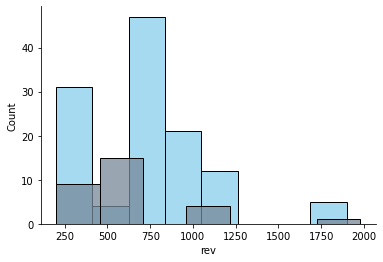

In [132]:
sns.histplot(checks_no_active_studs[checks_no_active_studs['grp'] == 'B'].rev, color='skyblue')
sns.histplot(checks_no_active_studs[checks_no_active_studs['grp'] == 'A'].rev, color='lightslategray')
sns.despine()

In [133]:
stats.shapiro(checks_no_active_studs.rev)

ShapiroResult(statistic=0.8611481785774231, pvalue=1.5626241967048315e-10)

In [134]:
mannwhitneyu(checks_no_active_studs[checks_no_active_studs['grp'] == 'A'].rev,
             checks_no_active_studs[checks_no_active_studs['grp'] == 'B'].rev)

MannwhitneyuResult(statistic=1593.0, pvalue=0.464814175436539)

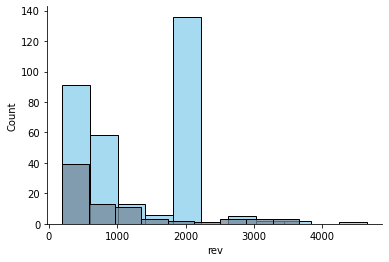

In [135]:
sns.histplot(checks_active_studs[checks_active_studs['grp'] == 'B'].rev, color='skyblue')
sns.histplot(checks_active_studs[checks_active_studs['grp'] == 'A'].rev, color='lightslategray')
sns.despine()

In [136]:
stats.shapiro(checks_no_active_studs.rev)

ShapiroResult(statistic=0.8611481785774231, pvalue=1.5626241967048315e-10)

In [137]:
mannwhitneyu(checks_active_studs[checks_active_studs['grp'] == 'A'].rev,
             checks_active_studs[checks_active_studs['grp'] == 'B'].rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

В результате теста Шапиро и Манна-Уитни можно сделать следующие выводы: 

датафрейм с пользователями, которые не заходили на платформу и совершили оплату:  
  + тест Шапиро показал, что распределение отличается от нормального (pvalue < 0.05), критерий Манна-Уитни показывает равенство распределений в группах A и B (pvalue > 0.05) 
  
  
датафрейм с пользователями, заходили на платформу и совершили оплату:  
  + тест Шапиро показал, что распределение отличается от нормального (pvalue < 0.05), критерий Манна-Уитни показывает pvalue < 0.05, следовательно, нельзя отклонить нулевую гипотезу о равенстве распределений. 
  

Учитывая полученные результаты, пользователи которые не заходили на платформу, но совершили оплаты в дальнейших расчетах учитываться не будут (т.к. возможно, проведение A/B теста не повлияло на решение этих пользователей, и тест показал равенство распределений). 

In [158]:
stats.levene(checks_active_studs[checks_active_studs['grp'] == 'A'].rev,
             checks_active_studs[checks_active_studs['grp'] == 'B'].rev)

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

В результате теста Левена pvalue = 0.08, что больше 0.05, следовательно, мы не можем отклонить нулевую гипотезу о том, что дисперсии равны.

## Метрики 

### Конверсия в покупку (CR)

***Гипотеза*** - изменение модели оплаты повлияло на конверсию.

Н0 - статистически значимой разницы в конверсии нет

In [138]:
active_studs

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [91]:
CR_df = pd.merge(active_studs, checks_active_studs[['student_id', 'rev']], how='left', on='student_id')\
.fillna(0)\
.assign(pay = lambda x: x.rev > 0)\
.groupby('grp', as_index=False)\
.agg({'rev': 'count', 'pay': 'sum'})\
.assign(CR = lambda x: (x.pay / x. rev).mul(100).round(2))

In [92]:
CR_df

,grp,rev,pay,CR
0,A,1538,78,5.07
1,B,6803,314,4.62


В результате можно заметить, что конверсия упала с 5.07% до 4.62% (на 8.8%). Проверим, статистически значима ли разница с помощию критерия ХИ-квадрат:

In [151]:
chi2, pvalue, table = proportion.proportions_chisquare(CR_df['pay'], CR_df['rev'])

In [152]:
pvalue

0.44547028437158964

Таким образом, pvalue = 0.44, что больше 0.05, значит нельзя отклонить гипотезу о том, что статистически значимых различий нет. Рассчитаем мощность ХИ-критерия:

In [154]:
CR_A = CR_df['CR'][0] / 100
CR_B = CR_df['CR'][1] / 100

In [155]:
#рассчитаем effect size
ES = np.sqrt(((CR_A - CR_B) ** 2)/CR_B )

In [156]:
#рассчитаем мощность критерия
smp.GofChisquarePower().solve_power(ES, nobs = min(CR_df['rev']), alpha = pvalue)

0.5797427318021494

In [157]:
#посчитаем, какое кол-во пользователей необходимо для того, чтобы получить желаемую мощность 0.8
round(smp.GofChisquarePower().solve_power(ES, nobs = None, alpha = 0.05, power = 0.8) / 2, 0)

8954.0

Мощность теста низкая - 0.58, при норме > 0.8. Это означает, что мало шансов увидеть статистически значимую разницу, если она есть, и в 42 случаев из 100 мы разницу не увидим. Из этого следует, что, возможно, статистически значимая разница между конверсиями есть, но данный тест ее не выявил.
Для увеличения мощности теста необходимо увелить количество пользователей в тестовой и контрольных группах до 8954 пользователей в каждой.  


### Средний чек 

***Гипотеза*** - изменение модели оплаты повлияло на средний чек (=ARPPU)

H0 - статистически значимых изменений нет

Для сравнения средних используются следующие методы:
- t-тест (критерий Стьюдента)
- bootstrap

При этом, условия для t-теста - нормальность распределения, гомогенность дисперсии (в нашем случае первое условие не соблюдено). Однако, t-тест возможно использовать на ненормальных данных (при больших размерах данных и отсутствии выбросов). Для bootstrap такие условия не требуются.
Для анализа используем оба способа и посмотрим, какие результаты они дадут. В случае если результаты будут отличаться, предпочтение будет отдаваться результатам bootstrap.

In [88]:
checks_active_studs.groupby('grp', as_index=False).agg({'rev': "mean"}).round(2)

,grp,rev
0,A,933.59
1,B,1257.88


In [76]:
stats.ttest_ind(checks_active_studs[checks_active_studs['grp'] == 'A'].rev.values, 
                checks_active_studs[checks_active_studs['grp'] == 'B'].rev.values)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

In [116]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    test, # числовые значения первой выборки
    control, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    bootstrap_conf_level = 0.95, # уровень значимости
    func = bs_stats.mean # применяемая статистика
):
    boot_data = bs.bootstrap_ab(
    test=test,
    ctrl=control,
    stat_func=func,
    compare_func=bs_compare.difference,
    num_iterations=boot_it,  
    return_distribution=True)
                       
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = np.quantile(pd_boot_data, [left_quant, right_quant])
    # визуализация    
    plt.figure(figsize=(15, 5))
    sns.histplot(pd_boot_data[0], bins=50, color='skyblue')    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=100, linestyle='--')
    plt.vlines(x=0, ymin=0, ymax=100, color='red', linestyle='--')    
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Bootstrap-распределение разниц среднего чека")
    plt.show()


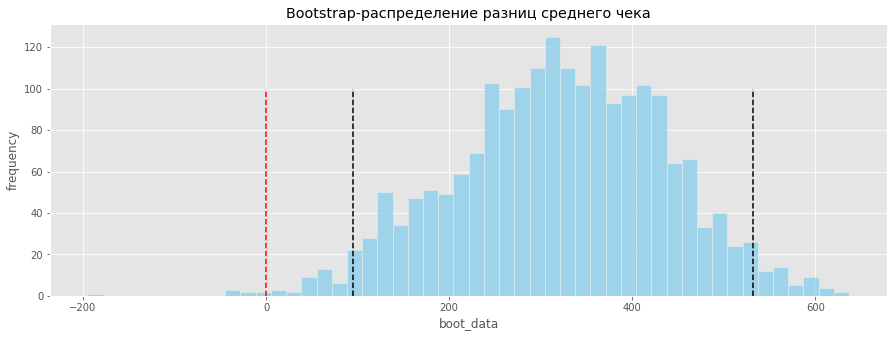

In [115]:
get_bootstrap(checks_active_studs[checks_active_studs['grp'] == 'B'].rev.values,
             checks_active_studs[checks_active_studs['grp'] == 'A'].rev.values,
             2000)

Оба теста показали наличие статистической значимой разницы в значениях среднего чека в тестовой и контрольной группах.
При этом, чек вырос с 933.59 р до 1257.88 р (на 34.7%).

### ARPU

Посмотрим, как изменение среднего чека и конверсии повлияло на ARPU. 

In [96]:
pd.merge(CR_df,
        checks_active_studs.groupby('grp', as_index=False).agg({'rev': "mean"}).round(2),
        on=['grp'])\
.rename(columns={'rev_y': 'avg_check'})\
.assign(ARPU= lambda x: ((x.CR / 100) * x.avg_check).round(2))

,grp,rev_x,pay,CR,avg_check,ARPU
0,A,1538,78,5.07,933.59,47.33
1,B,6803,314,4.62,1257.88,58.11


ARPU вырос с 47.33 до 58.11 р (на 22.8 %).

В ходе анализа были получены следующие результаты: 

- В данных были найдены и исключены из анализа 149 пользователей, которые не посещали приложение во время эксперимента. 
- В контрольной и тестовой группе разное количество пользователей. 

***Конверсия:***

- конверсия в покупку **(СR)** *упала* с **5.07%** до **4.62%** (на **8%**);

Конверсия была проанлизирована с помощью ХИ-квадрата, который **не выявил статистически значимых различий**. Однако стоит учитывать низкую мощность теста (0.58) и возможность наличия статистически значимых различий, которые тест не смог выявить. 

***Средний чек (ARPPU):***

- средний чек *увеличился* с **933.59** до **1257.88** рублей (на **34.7%**)

Средний чек был проанализирован с помощью t-теста и и bootstrap, которые показали одинаковый результат - **разница статистически значима**.

***ARPU:***

- ARPU *повысился* с **47.33** до **58.11** рублей (на **22.8%**)

В результате ARPU повысился, не смотря на уменьшении конверсии (уменьшение конверсии нивелировалось увеличением среднего чека).

**Заключение и рекомендации:**

В целом, новая модель оплаты показала **положительные результаты (увеличился доход)**, поэтому **можно выкатывать новую модель** на всех пользователей. 

---

## Задание 2. SQL

### 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

2.1.2 Задача

Дана таблица peas:

- st_id - ID ученика
- timest - Время решения карточки
- correct	- Правильно ли решена горошина?
- subject	- Дисциплина, в которой находится горошина

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

SELECT COUNT(DISTINCT st_id) as diligent_students

FROM (
    SELECT st_id, timest, SUM(correct) OVER w AS correct_sum 
    FROM peas
    WHERE EXTRACT(MONTH FROM timest) = 3 AND EXTRACT(YEAR FROM timest) = 2020
    WINDOW w AS  (PARTITION BY st_id    
                  ORDER BY timest 
                  RANGE BETWEEN '0 hour' PRECEDING AND '1 hour' FOLLOWING)) AS a
        
WHERE correct_sum  > 20


------

### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: peas (см. выше), studs:

- st_id - ID ученика
- test_grp - Метка ученика в данном эксперименте

и checks:

- st_id  - ID ученика
- sale_time - Время покупки
- money - Цена, по которой приобрели данный курс
- subject - Дисциплина, на которую приобрели полный доступ

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

WITH active_studs AS -- активные пользователи (правильно решили в день 10 задач)
    (SELECT st_id, timest::date, subject, 
    SUM(correct) AS correct_count 
    FROM peas
    GROUP BY st_id, timest::date, subject
    HAVING SUM(correct) >= 10 )

SELECT q.test_grp, 
AVG(q.money) AS ARPU, 
AVG(q1.money) AS ARPAU,
ROUND(100*SUM(q.purchases::int) / COUNT(DISTINCT q.st_id), 2) AS CR,
ROUND(100*SUM(q1.purchases::int) / COUNT(DISTINCT q1.st_id), 2) AS CR_active,
ROUND(100*SUM(q2.purchases_math::int) / COUNT(DISTINCT q2.st_id), 2) AS CR_active_for_math

FROM (
    SELECT studs.st_id AS st_id, -- все пользователи
    test_grp, 
    SUM(COALESCE(money, 0)) as money,  
    (COUNT(checks.subject)) > 0 AS purchases  
    FROM studs  
    LEFT JOIN checks 
    ON studs.st_id = checks.st_id 
    GROUP BY studs.st_id, test_grp
    ) AS q
    
LEFT JOIN 
    (SELECT studs.st_id AS st_id, -- активные пользователи
    test_grp, 
    SUM(COALESCE(money, 0)) as money,  
    (COUNT(checks.subject)) > 0 AS purchases  
    FROM studs  
    LEFT JOIN  checks 
    ON studs.st_id = checks.st_id 
    WHERE studs.st_id IN (SELECT st_id FROM active_studs)
    GROUP BY studs.st_id, test_grp
    ) AS q1
ON q.st_id = q1.st_id
    
LEFT JOIN
    (SELECT studs.st_id AS st_id, -- активные пользователи, которые решали задачи по математике и купили курсы по математике
    test_grp, 
    SUM(COALESCE(money, 0)) as money, 
    SUM((checks.subject = 'math')::INT) > 0 AS purchases_math 
    FROM studs  
    LEFT JOIN  checks 
    ON studs.st_id = checks.st_id 
    WHERE studs.st_id IN 
            (SELECT st_id 
            FROM active_studs 
            WHERE subject = 'math')
    GROUP BY studs.st_id, test_grp
    ) AS q2
ON q.st_id = q2.st_id
  
GROUP BY q.test_grp


----

## Задание 3. Python

### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.